In [1]:
import scipy.sparse as sp
from dgl.nn import HeteroEmbedding
import itertools
import torch.distributed as dist
from torch import Tensor
import numpy as np
import torch
import queue
import random
import pandas as pd
import pickle
import dgl.nn as dglnn
import dgl
from torch.nn.parallel import DistributedDataParallel
from torch.optim import SparseAdam
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import init
import torch.nn.functional as F
import tqdm
from torch.nn.parallel import DistributedDataParallel
from dgl.base import NID
from dgl.convert import to_homogeneous, to_heterogeneous
from dgl.random import choice
from dgl.sampling import random_walk
import time
from dgl.data.utils import save_graphs
from dataclasses import dataclass
import datetime
from sklearn.model_selection import train_test_split
import warnings
import dgl.nn as dglnn
import os
import gc
os.environ['DGLBACKEND'] = 'pytorch'
warnings.filterwarnings('ignore')


def readFile(filePath):
    with open(f"../../dataset/zhihu_publish/{filePath}.pkl", 'rb') as file:
        return pickle.loads(file.read())


In [2]:
Answers_dev=readFile('Answers_dev')
Answers_test=readFile('Answers_test')
Questions=readFile('Questions')
Users=readFile('Users')
Topics=readFile('Topics')

In [3]:
Topics=readFile('Topics')

In [5]:
user_following_user=[]
for u,f in zip(Users.uid,Users.followings):
    for v in f:
        user_following_user.append([u,v])
user_follower_user=[]
for u,f in zip(Users.uid,Users.followers):
    for v in f:
        user_follower_user.append([u,v])
user_answer_write=[]
for u,f in zip(Users.uid,Users.writtenAnswers):
    try:
        for v in f:
            user_answer_write.append([u,v])
    except:
        pass
user_following_topic=[]
for u,f in zip(Users.uid,Users.followedTopics):
    try:
        for v in f:
            user_following_topic.append([u,v])
    except:
        pass
user_ask_question=[]
for u,f in zip(Users.uid,Users.askedQuestions):
    try:
        for v in f:
            user_ask_question.append([u,v])
    except:
        pass
user_follow_question=[]
for u,f in zip(Users.uid,Users.followedQuestions):
    try:
        for v in f:
            user_follow_question.append([u,v])
    except:
        pass
user_commment_answer=[]
for u,f in zip(Users.uid,Users.commentedAnswers):
    try:
        for v in f:
            user_commment_answer.append([u,v])
    except:
        pass
question_belongto_topic=[]
for u,f in zip(Questions.questionId,Questions.questionTopics):
    try:
        for v in f:
            question_belongto_topic.append([u,v])
    except:
        pass
question_have_answer=[]
for u,f in zip(Questions.questionId,Questions.answers):
    try:
        for v in f:
            question_have_answer.append([u,v])
    except:
        pass

In [6]:
data={
('user', 'write', 'answer') :(torch.tensor(user_answer_write)[:,0],torch.tensor(user_answer_write)[:,1]),
('answer', 're_write', 'user') :(torch.tensor(user_answer_write)[:,1],torch.tensor(user_answer_write)[:,0]),
("user", "user_follower_user", "user"):(torch.tensor(user_follower_user)[:,0],torch.tensor(user_follower_user)[:,1]),
("user", "user_following_user", "user"):(torch.tensor(user_following_user)[:,0],torch.tensor(user_following_user)[:,1]),
("user", "user_following_topic", "topic"):(torch.tensor(user_following_topic)[:,0],torch.tensor(user_following_topic)[:,1]),
("topic", "re_user_following_topic", "user"):(torch.tensor(user_following_topic)[:,1],torch.tensor(user_following_topic)[:,0]),
("user", "user_following_question", "question"):(torch.tensor(user_follow_question)[:,0],torch.tensor(user_follow_question)[:,1]),
("question", "re_user_following_question", "user"):(torch.tensor(user_follow_question)[:,1],torch.tensor(user_follow_question)[:,0]),
("user", "ask", "question"):(torch.tensor(user_ask_question)[:,0],torch.tensor(user_ask_question)[:,1]),
("question", "re_ask", "user"):(torch.tensor(user_ask_question)[:,1],torch.tensor(user_ask_question)[:,0]),
("question", "belongto", "topic"):(torch.tensor(question_belongto_topic)[:,0],torch.tensor(question_belongto_topic)[:,1]),
("topic", "re_belongto", "question"):(torch.tensor(question_belongto_topic)[:,1],torch.tensor(question_belongto_topic)[:,0]),
("question", "have", "answer"):(torch.tensor(question_have_answer)[:,0],torch.tensor(question_have_answer)[:,1]),
("answer", "re_have", "question"):(torch.tensor(question_have_answer)[:,1],torch.tensor(question_have_answer)[:,0])
}
g=dgl.heterograph(data)

In [7]:
g

Graph(num_nodes={'answer': 460857, 'question': 597982, 'topic': 92261, 'user': 23552},
      num_edges={('answer', 're_have', 'question'): 460857, ('answer', 're_write', 'user'): 440857, ('question', 'belongto', 'topic'): 2156267, ('question', 'have', 'answer'): 460857, ('question', 're_ask', 'user'): 36947, ('question', 're_user_following_question', 'user'): 937205, ('topic', 're_belongto', 'question'): 2156267, ('topic', 're_user_following_topic', 'user'): 344405, ('user', 'ask', 'question'): 36947, ('user', 'user_follower_user', 'user'): 29029, ('user', 'user_following_question', 'question'): 937205, ('user', 'user_following_topic', 'topic'): 344405, ('user', 'user_following_user', 'user'): 128923, ('user', 'write', 'answer'): 440857},
      metagraph=[('answer', 'question', 're_have'), ('answer', 'user', 're_write'), ('question', 'topic', 'belongto'), ('question', 'answer', 'have'), ('question', 'user', 're_ask'), ('question', 'user', 're_user_following_question'), ('user', 'questi

In [8]:
meta_paths_one=[]
for u,topics in zip(Users.uid,Users.followedTopics):
    try:
        meta_paths_one+=[[u,t] for t in topics]
    except:
        pass

In [9]:
meta_paths_one=pd.DataFrame(meta_paths_one,columns=['uid','topic'])
meta_paths_one.to_csv('meta_paths_one_zhihu.csv',index=False)

In [10]:
meta_paths_two=[]
for u,questions in zip(Users.uid,Users.followedQuestions):
    try:
        for questionId in questions:
            try:
                meta_paths_two+=[[u,t] for t in Questions[Questions['questionId']==questionId].questionTopics.values[0]]
            except:
                pass
    except:
        pass

In [11]:
meta_paths_two=pd.DataFrame(meta_paths_two,columns=['uid','topic'])
meta_paths_two.to_csv('meta_paths_two_zhihu.csv',index=False)

In [12]:
meta_paths_three=[]
for u,questions in zip(Users.uid,Users.askedQuestions):
    try:
        for questionId in questions:
            try:
                meta_paths_three+=[[u,t] for t in Questions[Questions['questionId']==questionId].questionTopics.values[0]]
            except:
                pass
    except:
        pass

In [13]:
meta_paths_three=pd.DataFrame(meta_paths_three,columns=['uid','topic'])
meta_paths_three.to_csv('meta_paths_three_zhihu.csv',index=False)

In [14]:
save_graphs('./graph_without_feature_zhihu',[g])

In [40]:
from dgl.data.utils import load_graphs
glist, label_dict = load_graphs('./graph_without_feature_zhihu')
g=glist[0]

In [5]:
def compute_loss(pos_score, neg_score):
    # 间隔损失
    n_edges = pos_score.shape[0]
    return (1 - pos_score.unsqueeze(1) + neg_score.view(n_edges, -1)).clamp(min=0).mean()
class StochasticTwoLayerRGCN(nn.Module):
    def __init__(self, in_feat, hidden_feat, out_feat, rel_names):
        super().__init__()
        self.conv1 = dglnn.HeteroGraphConv({
                rel : dglnn.GraphConv(in_feat, hidden_feat, norm='right')
                for rel in rel_names
            })
        self.conv2 = dglnn.HeteroGraphConv({
                rel : dglnn.GraphConv(hidden_feat, out_feat, norm='right')
                for rel in rel_names
            })

    def forward(self, blocks, x):
        x = self.conv1(blocks[0], x)
        x = self.conv2(blocks[1], x)
        return x
class ScorePredictor(nn.Module):
    def forward(self, edge_subgraph, x):
        with edge_subgraph.local_scope():
            edge_subgraph.ndata['x'] = x
            for etype in edge_subgraph.canonical_etypes:
                edge_subgraph.apply_edges(
                    dgl.function.u_dot_v('x', 'x', 'score'), etype=etype)
            return edge_subgraph.edata['score']

class Model(nn.Module):
    def __init__(self,embeddingDict, in_features, hidden_features, out_features, num_classes,
                 etypes):
        super().__init__()
        self.embeddings=HeteroEmbedding(embeddingDict,128)
        self.rgcn = StochasticTwoLayerRGCN(
            in_features, hidden_features, out_features, etypes)
        self.pred = ScorePredictor()

    def forward(self, positive_graph, negative_graph, blocks, x):
        x=self.embeddings(x)
        x = self.rgcn(blocks, x)
        pos_score = self.pred(positive_graph, x)
        neg_score = self.pred(negative_graph, x)
        return pos_score, neg_score

In [6]:
embeddingDict={nodeType:g.num_nodes(nodeType) for nodeType in g.ntypes}

In [7]:
Questions=readFile('Questions')

In [8]:
Users=readFile('Users')

In [9]:
qid2inedx={q:i for q,i in zip(Questions.questionId.values,Questions.index)}
uid2inedx={q:i for q,i in zip(Users.uid.values,Users.index)}

In [10]:
meta_paths_one=pd.read_csv('meta_paths_one_zhihu.csv')
meta_paths_two=pd.read_csv('meta_paths_two_zhihu.csv')
meta_paths_three=pd.read_csv('meta_paths_three_zhihu.csv')

In [11]:
meta_paths=pd.concat([meta_paths_one,meta_paths_two,meta_paths_three])

In [12]:
meta_paths.drop_duplicates(inplace=True)

In [13]:
meta_paths.reset_index(drop=True,inplace=True)

In [14]:
Answers_train=readFile('Answers_train')
Answers_train=Answers_train[['answerId','questionId']]
answer_topic=Answers_train.merge(Questions[['questionId','questionTopics']],on='questionId',how='left')[['answerId','questionTopics']]
answer_topic.index=answer_topic.answerId.values

In [15]:
del Answers_train,meta_paths_one,meta_paths_two,meta_paths_three
gc.collect()

0

In [17]:
def sampleNegtiveMetapathOne(x):
    questionId=x['questionId']
    uid=x['users'][0]
    belongToTopics=Questions.loc[qid2inedx[questionId]]['questionTopics']
    negIds=[]
    for i in belongToTopics:
        negIds+=meta_paths[meta_paths_two['topic']==i].uid.values.tolist()
    negIds=set(negIds)
    return list(negIds)

In [18]:
class NegativeSamplerFunction(object):
    def __init__(self,userNodes,k):
        self.userNodes=userNodes
        self.k=k
    def __call__(self, g, eids_dict):
        result_dict = {}
        etype=('user', 'write', 'answer')
        eids=eids_dict[('user', 'write', 'answer')]
        src, dst = g.find_edges(eids, etype=etype)
        dst = dst.repeat_interleave(self.k)
        src=torch.tensor(np.random.choice(self.userNodes,len(dst),replace=True))
        result_dict[etype] = (src, dst)
        return result_dict

In [16]:
class NegativeSamplerFunctionEnchanced(object):
    def __init__(self,userNodes,k):
        self.k=k
        self.userNodes=userNodes
    def __call__(self, g, eids_dict):
        result_dict = {}
        etype=('user', 'write', 'answer')
        eids=eids_dict[('user', 'write', 'answer')]
        src, dst = g.find_edges(eids, etype=etype)
        src=[]
        for d in dst.tolist():
            _,toipcs=answer_topic.loc[d]
            negIds=[]
            for i in toipcs:
                negIds+=meta_paths[meta_paths['topic']==i].uid.values.tolist()
            negIds=set(negIds)
            try:
                negIds=list(np.random.choice(list(negIds),self.k))
            except:
                negIds=list(np.random.choice(self.userNodes,self.k,replace=False))
            src+=negIds
        dst = dst.repeat_interleave(self.k)
        result_dict[etype] = (torch.tensor(src), dst)
        return result_dict

In [17]:
train_eid_dict = {'write': g.edges(etype='write', form='eid')}
sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
sampler = dgl.dataloading.as_edge_prediction_sampler(
    sampler, negative_sampler=NegativeSamplerFunctionEnchanced(g.nodes('user'),5),
    exclude='reverse_types',
    reverse_etypes={'write': 're_write', 're_write': 'write'})
dataloader = dgl.dataloading.DataLoader(
    g, train_eid_dict, sampler,
    batch_size=256,
    shuffle=True,
    drop_last=False,
    num_workers=32)

In [18]:
torch.cuda.empty_cache()

In [19]:
device='cuda:1'

In [20]:
linkPredictionModel = Model(embeddingDict,128, 128, 128, 2, g.etypes)
linkPredictionModel = linkPredictionModel.to(device)

In [21]:
opt = torch.optim.Adam(linkPredictionModel.parameters())
#opt=SparseAdam(linkPredictionModel.parameters(), lr=0.025)
import tqdm
i=0
for input_nodes, positive_graph, negative_graph, blocks in tqdm.tqdm(dataloader):
    blocks = [b.to(device) for b in blocks]
    input_nodes={key:input_nodes[key].to(device) for key in input_nodes.keys()}
    positive_graph = positive_graph.to(device)
    negative_graph = negative_graph.to(device)
    pos_score, neg_score = linkPredictionModel(positive_graph, negative_graph, blocks, input_nodes)
    loss = compute_loss(pos_score[('user','write','answer')],neg_score[('user','write','answer')])
    opt.zero_grad()
    loss.backward()
    opt.step()
    i+=1
    if i%50==0:
        gc.collect()
        torch.cuda.empty_cache()

100%|██████████| 1723/1723 [26:53<00:00,  1.07it/s] 


In [22]:
torch.save(linkPredictionModel, './navie_link_prediction/linkPredictionModel_full_exp_zhihu_embedding128.pkl')

In [23]:
def sampleNegtiveMetapaths(x):
    questionId=x['questionId']
    uid=x['users'][0]
    belongToTopics=Questions.loc[qid2inedx[questionId]]['questionTopics']
    negIds=[]
    for i in belongToTopics:
        negIds+=meta_paths[meta_paths['topic']==i].uid.values.tolist()
    negIds=set(negIds)
    if len(negIds)<1:
        negIds=list(g.nodes('user'))
    return list(negIds)

In [35]:
Answers_dev=readFile('Answers_dev')
Answers_test=readFile('Answers_test')

In [36]:
Answers_dev=Answers_dev.head(100)

In [37]:
userIds,answerIds=[],[]
for u,a in zip(Answers_dev.users.values,Answers_dev.answerId.values):
    userIds.append(u[0])
    answerIds.append(a)

In [38]:
Answers_dev['sampleNegtiveMetapathOne']=Answers_dev.apply(sampleNegtiveMetapaths,axis=1)

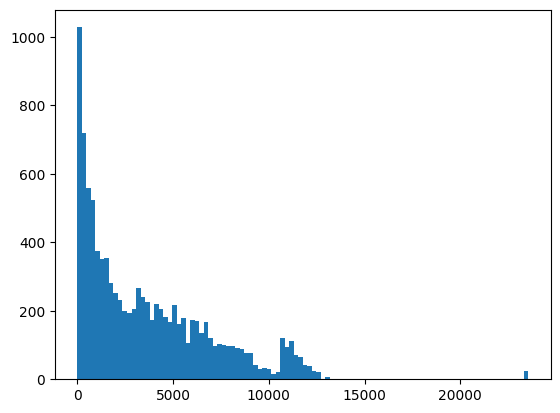

In [30]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.hist(Answers_dev.sampleNegtiveMetapathOne.apply(len),100)
plt.show()

In [41]:
numWriteEdges=g.num_edges('write')

In [42]:
g = dgl.add_edges(g,torch.tensor(userIds),torch.tensor(answerIds),etype='write')

In [30]:
class choosedUserSampler(object):
    def __init__(self,userNodes,answerNodes):
        self.userNodes=userNodes
        self.answerNodes=answerNodes
    def __call__(self, g, eids_dict):
        result_dict = {}
        etype=('user', 'write', 'answer')
        eids=eids_dict[('user', 'write', 'answer')]
        src = torch.tensor(self.userNodes[eids-numWriteEdges]).view(-1)
        dst = self.answerNodes[eids-numWriteEdges].repeat_interleave(len(src))
        result_dict[etype] = (src, dst)
        return result_dict

In [43]:
import gc
gc.collect()

427

In [31]:
def testModelChoosedUser(G,Edges,Model,userIds,AnsweIds):
    sampler = dgl.dataloading.MultiLayerFullNeighborSampler(2)
    sampler = dgl.dataloading.as_edge_prediction_sampler(
        sampler, negative_sampler=choosedUserSampler(userIds,torch.tensor(AnsweIds)),
        exclude='reverse_types',
        reverse_etypes={'write': 're_write', 're_write': 'write'})
    dataloader = dgl.dataloading.DataLoader(
        G, Edges, sampler,
        batch_size=1,
        shuffle=False,
        drop_last=False,
        num_workers=1)
    posS,negS=[],[]
    with torch.no_grad():
        for input_nodes, positive_graph, negative_graph, blocks in tqdm.tqdm(dataloader):
            blocks = [b.to(device) for b in blocks]
            input_nodes={key:input_nodes[key].to(device) for key in input_nodes.keys()}
            positive_graph = positive_graph.to(device)
            negative_graph = negative_graph.to(device)
            pos_score, neg_score = linkPredictionModel(positive_graph, negative_graph, blocks, input_nodes)
            posS.append(pos_score[('user','write','answer')].cpu().detach())
            negS.append(neg_score[('user','write','answer')].cpu().detach())
    return posS,negS

In [44]:
dev_eid_dict = {'write': g.edges(etype='write', form='eid')[-len(Answers_dev):]}

In [32]:
linkPredictionModel=torch.load('./navie_link_prediction/linkPredictionModel_full_exp_zhihu_embedding128_train_norecall.pkl')
linkPredictionModel = linkPredictionModel.to(device)

In [45]:
Pos,Neg=testModelChoosedUser(g,dev_eid_dict,linkPredictionModel,list(Answers_dev.sampleNegtiveMetapathOne.values),Answers_dev.answerId.values)

100%|██████████| 100/100 [01:43<00:00,  1.03s/it]


In [46]:
labels=Answers_dev.users.apply(lambda x:x[0])

In [47]:
def accEltaK(preds,recalledUsers,labels,k):
    s=0
    for pred,users,label in zip(preds,recalledUsers,labels):
        pred=np.array(pred).reshape(-1)
        users=np.array(users)
        K=min(k,len(pred))
        indexs=np.argpartition(pred,-K)[-K:]
        if label in users[indexs]:
            s+=1
    return s/len(Neg)*100

In [48]:
accEltaK(Neg,list(Answers_dev.sampleNegtiveMetapathOne.values),labels,100)

54.0

In [49]:
accEltaK(Neg,list(Answers_dev.sampleNegtiveMetapathOne.values),labels,10)

32.0

In [50]:
accEltaK(Neg,list(Answers_dev.sampleNegtiveMetapathOne.values),labels,5)

28.999999999999996

In [51]:
accEltaK(Neg,list(Answers_dev.sampleNegtiveMetapathOne.values),labels,1)

16.0

In [52]:
with open(f"Neg.pkl",'wb') as file:
    pickle.dump(Neg,file)

In [53]:
ans=list(Answers_dev.sampleNegtiveMetapathOne.values)

In [54]:
with open(f"sampleNegtiveMetapath.pkl",'wb') as file:
    pickle.dump(ans,file)

In [55]:
with open(f"labels.pkl",'wb') as file:
    pickle.dump(labels,file)